In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE

In [2]:
%matplotlib inline

In [3]:
bike = pd.read_csv('day.csv')

In [4]:
bike.head(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
5,6,06-01-2018,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,88,1518,1606
6,7,07-01-2018,1,0,1,0,5,1,2,8.057402,10.44195,49.8696,11.304642,148,1362,1510
7,8,08-01-2018,1,0,1,0,6,0,2,6.765000,8.11270,53.5833,17.875868,68,891,959
8,9,09-01-2018,1,0,1,0,0,0,1,5.671653,5.80875,43.4167,24.250650,54,768,822
9,10,10-01-2018,1,0,1,0,1,1,1,6.184153,7.54440,48.2917,14.958889,41,1280,1321


It looks like the Date present in `dteday` and the values present in `holiday`, `weekday` and `workingday` are not matching.
Because,
- 1st Jan 2018 was a Monday, however the weekday value is `6` and working day is `0`
    - weekday usually starts with Sunday=0, Monday=1 and so on.
    - working day by definition is 1 if the it is not a holiday and not a weekend. Since 1st Jan 2018 was Monday the working day value should have been 1.
    
However, since all the features that can be extracted from `dteday` is already present in the data (like day of week, month and year) we do not need this feature. Hence assuming the values in `weekday` and `workingday` are valid.
It can be also observed from the `cnt` value that weekends are having less count than the weekdays.

In [5]:
bike.drop(columns=['dteday'], inplace=True)

Ckecking the data information for NULLS

In [6]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(11)
memory usage: 85.7 KB


There are NO NULL values in the dataset. 
Also, the datatypes are proper for all the features.

In [7]:
#Checking for overall statistics of the dataset
bike.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


## Data Cleaning

As per the data dictionary, the feature `instant` is not relavent to the usecase and can be removed

The feaures `casual` and `registered` are directly correlated with the target column `cnt`.

`casual` + `registered` = `cnt`, hence we will drop these 2 columns.


In [8]:
bike.drop(columns=['instant','casual','registered'], inplace=True)

In [9]:
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [86]:
categorical_features = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
numerical_features = ['temp','atemp','hum','windspeed','cnt']

In [13]:
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,Jan,0,Sat,0,Misty,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,Jan,0,Sun,0,Misty,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


## Visualization
- Univariate and bivariate

We will see all the features togather using seaborn pair plot.

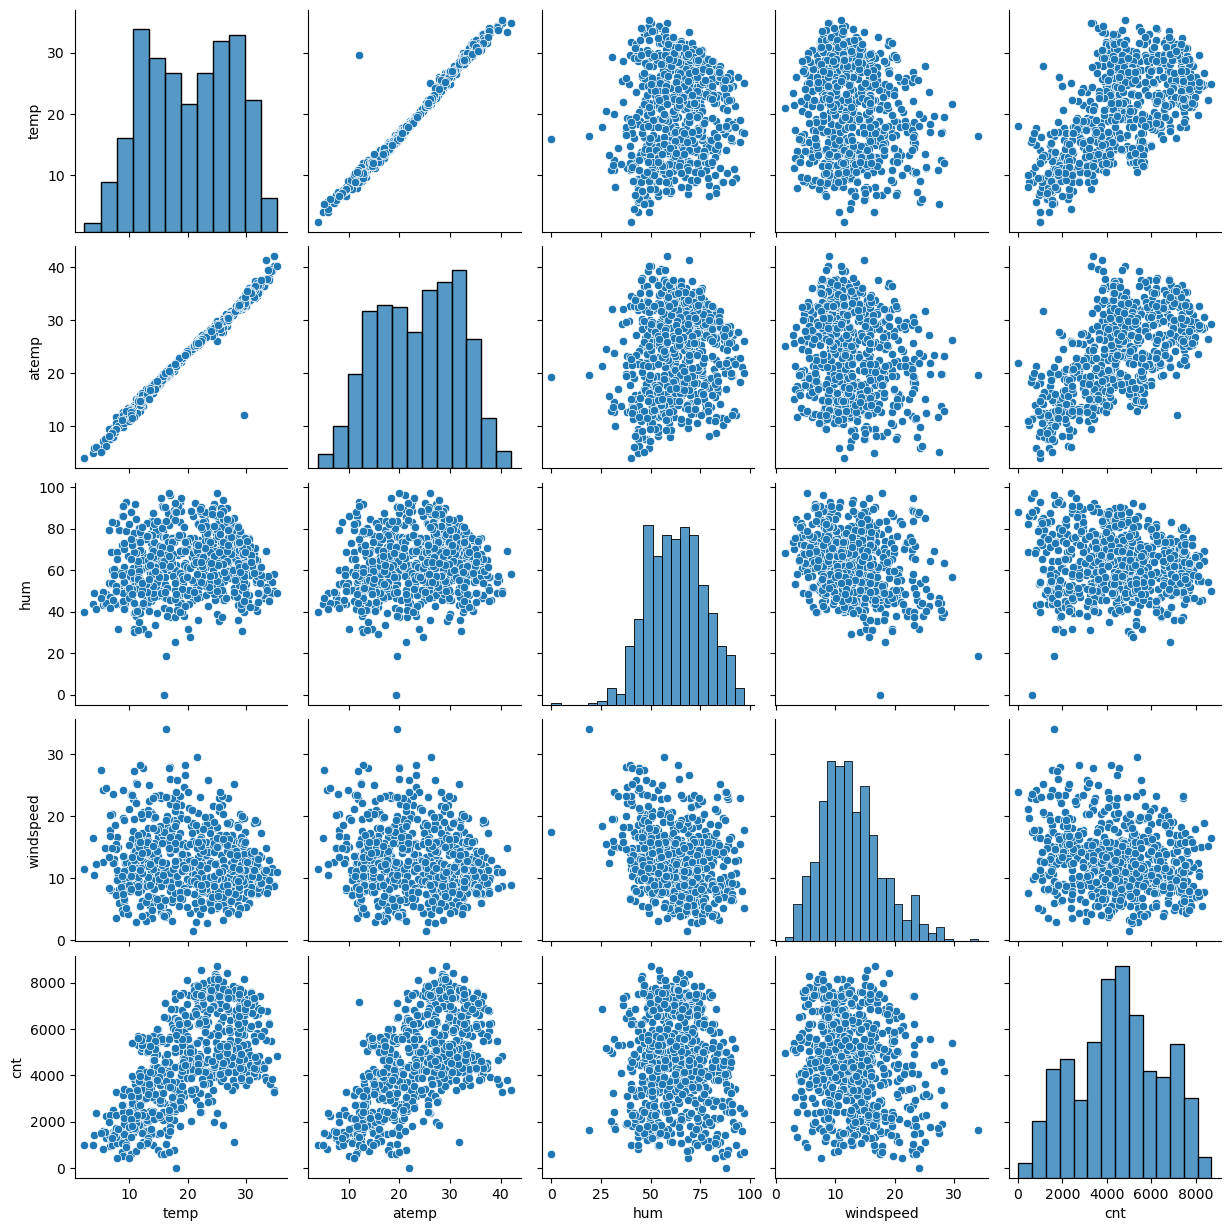

In [11]:
sns.pairplot(bike[numerical_features])

Looking at above pairplot, on high level we can have below observations
1. temp and atemp featres are highly correlated
2. There is a linear relationship between temp/atemp and the target variable.
3. There is not very good liner relationship between hum and windspeed variables with target variable.
4. All the numerical features are well distributed

We will verify the above claim individually.

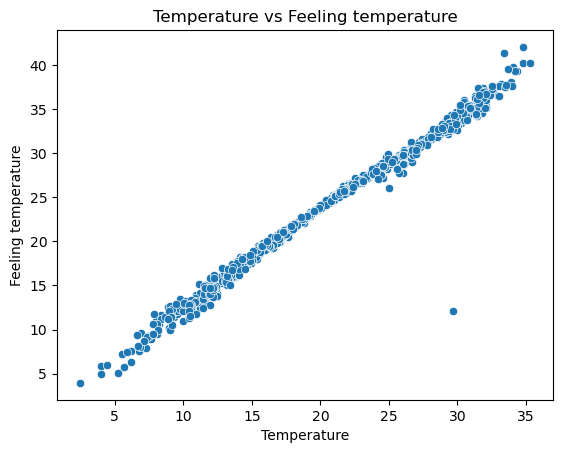

In [12]:
#Checking for relation between temp and atemp
#1. Using scatter plot
sns.scatterplot(data=bike, x='temp', y='atemp')
plt.xlabel('Temperature')
plt.ylabel('Feeling temperature')
plt.title("Temperature vs Feeling temperature")
plt.show()

<AxesSubplot:>

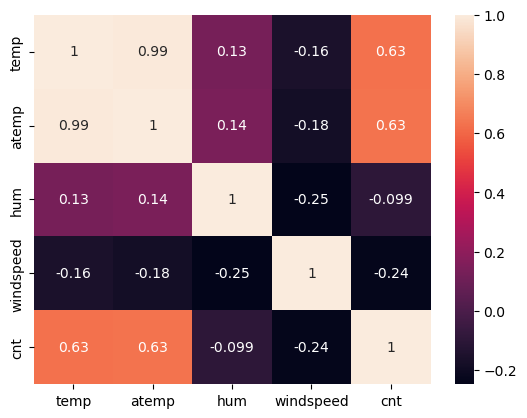

In [13]:
#2. using correlation plot
sns.heatmap(bike[numerical_features].corr(), annot=True)

With above 2 plots, scatter and correlation, it is evident that the `temp` and `atemp` are highly correlated and we can remove one of them.

We will remove `atemp` from the dataset.

In [14]:
bike.drop(columns=['atemp'], inplace=True)

#### Visualizing categorical features

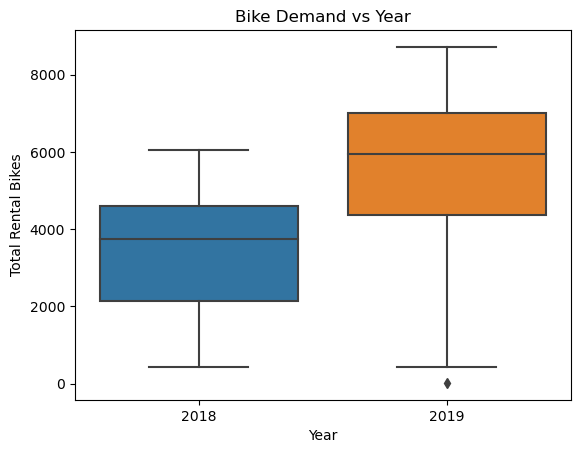

In [15]:
sns.boxplot(data=bike, y='cnt', x='yr')
plt.title('Bike Demand vs Year')
plt.ylabel('Total Rental Bikes')
plt.xlabel('Year')
plt.xticks(ticks=[0,1],labels=['2018','2019'])
plt.show()

It is clear from above box plot that the demand for rental bikes have increased from 2018 to 2019.

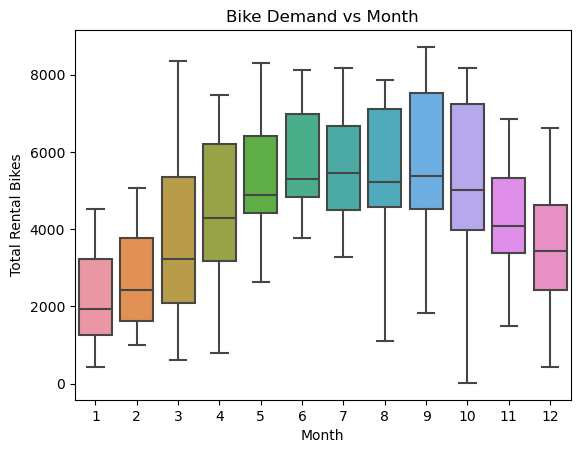

In [16]:
sns.boxplot(data=bike, y='cnt', x='mnth')
plt.title('Bike Demand vs Month')
plt.ylabel('Total Rental Bikes')
plt.xlabel('Month')
plt.show()

It is clear from above box plot that the demand for rental bikes have are increasing from Jan to July and then decreases towards the end of the year.

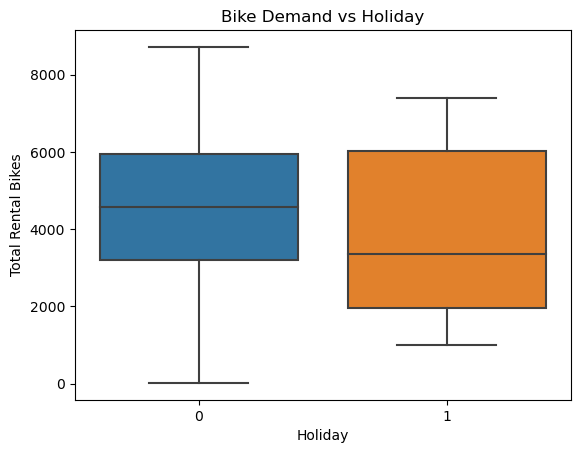

In [17]:
sns.boxplot(data=bike, y='cnt', x='holiday')
plt.title('Bike Demand vs Holiday')
plt.ylabel('Total Rental Bikes')
plt.xlabel('Holiday')
plt.show()

There is not much difference in the upper bound for demand over the holiday vs non-holiday, however the median demand on holiday is lower than the non-holiday.

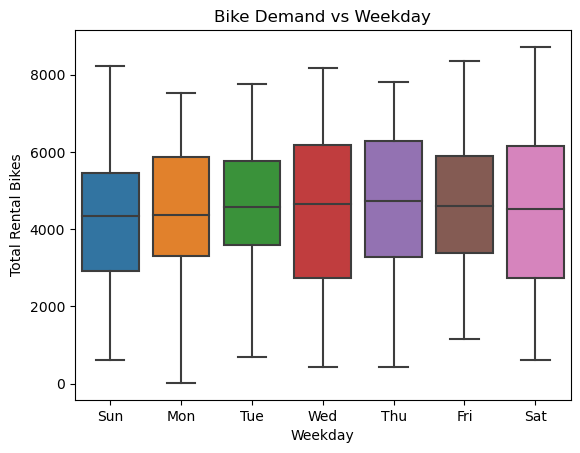

In [18]:
sns.boxplot(data=bike, y='cnt', x='weekday')
plt.title('Bike Demand vs Weekday')
plt.ylabel('Total Rental Bikes')
plt.xlabel('Weekday')
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'])
plt.show()

The median demand on all the weekdays is similar.

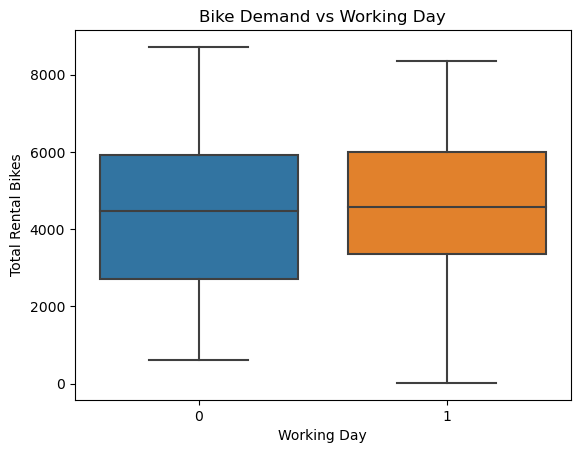

In [19]:
sns.boxplot(data=bike, y='cnt', x='workingday')
plt.title('Bike Demand vs Working Day')
plt.ylabel('Total Rental Bikes')
plt.xlabel('Working Day')
plt.show()

There is no difference in the bike demand whether the day is working day or not.

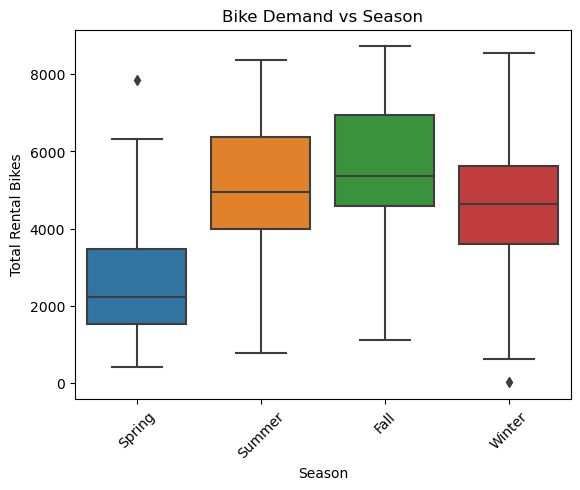

In [20]:
sns.boxplot(data=bike, y='cnt', x='season')
plt.title('Bike Demand vs Season')
plt.ylabel('Total Rental Bikes')
plt.xlabel('Season')
plt.xticks(ticks=[0,1,2,3], labels=['Spring','Summer','Fall','Winter'],rotation=45)
plt.show()

There is a high demand for rental bikes in summer and fall as compared to winter and spring.

In Spring season, the demand for rental bike is the lowest.

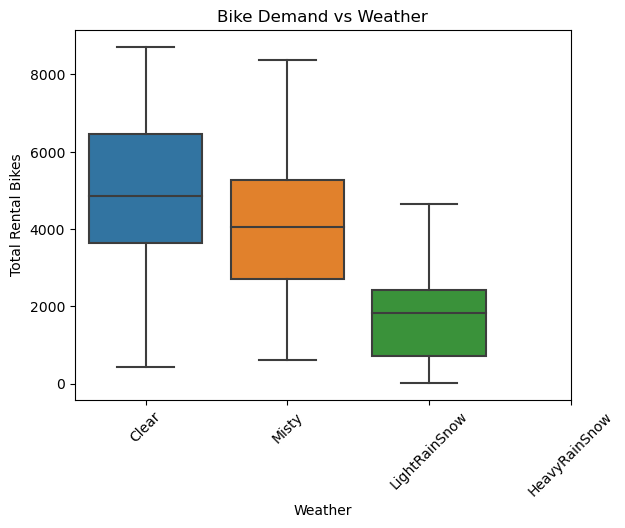

In [21]:
sns.boxplot(data=bike, y='cnt', x='weathersit')
plt.title('Bike Demand vs Weather')
plt.ylabel('Total Rental Bikes')
plt.xlabel('Weather')
plt.xticks(ticks=[0,1,2,3], labels=['Clear','Misty','LightRainSnow','HeavyRainSnow'],rotation=45)
plt.show()

There is a high demand for rental bikes in when the weather is clear as the demand goes on decreasing as the weather worsens.

## Outlier checking and treatment

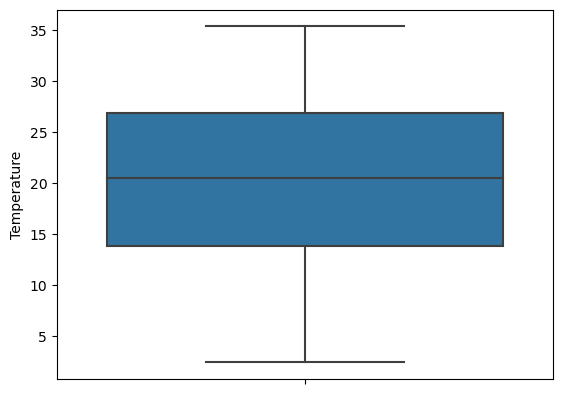

In [22]:
sns.boxplot(data=bike, y='temp')
plt.ylabel('Temperature')
plt.show()

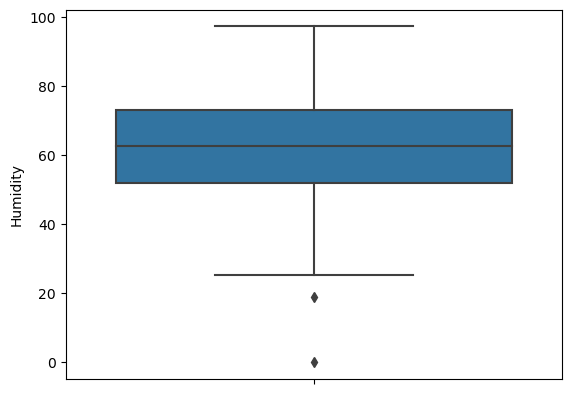

In [23]:
sns.boxplot(data=bike, y='hum')
plt.ylabel('Humidity')
plt.show()

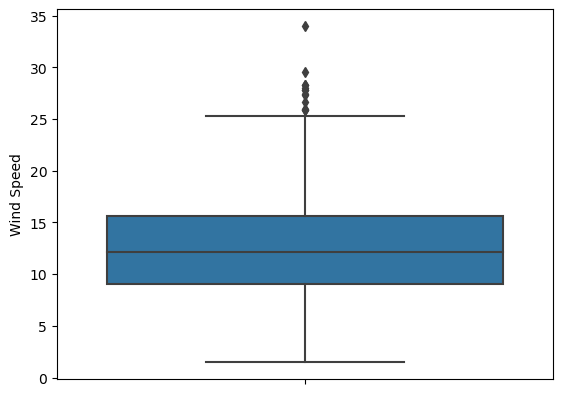

In [24]:
sns.boxplot(data=bike, y='windspeed')
plt.ylabel('Wind Speed')
plt.show()

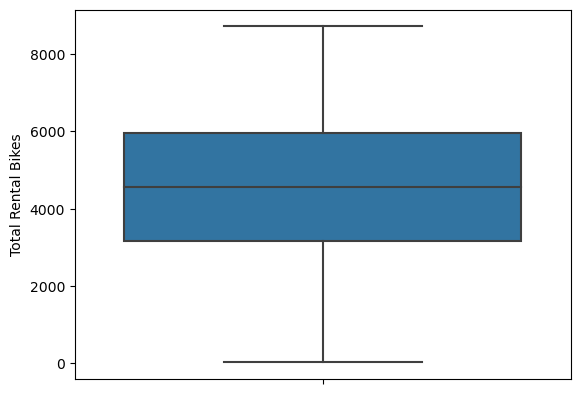

In [25]:
sns.boxplot(data=bike, y='cnt')
plt.ylabel('Total Rental Bikes')
plt.show()

Above boxplots shows that 
1. There are no outliers in `temperature` and `count`
2. There are few outliers in `Humidity` and `Wind Speed`

In [26]:
#Removing outliers from humidity using IQR method
Q1,Q3 = bike.hum.quantile([0.25,0.75])
IQR = Q3-Q1

lower_bound = Q1 - 1.5*IQR

In [27]:
bike['hum'] = bike.hum.apply(lambda x: x if x>=lower_bound else lower_bound)

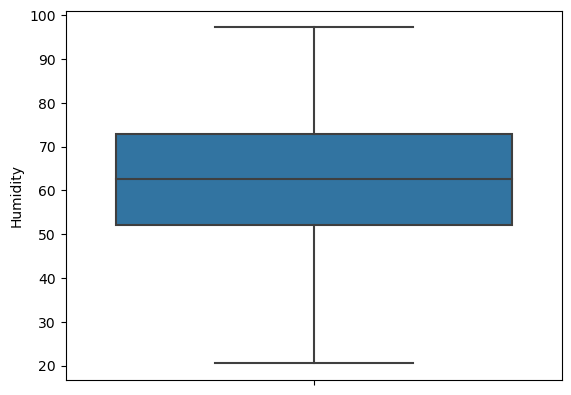

In [28]:
sns.boxplot(data=bike, y='hum')
plt.ylabel('Humidity')
plt.show()

In [29]:
#Removing outliers from wind speed using IQR method
Q1,Q3 = bike.windspeed.quantile([0.25,0.75])
IQR = Q3-Q1

upper_bound = Q3 + 1.5*IQR

In [30]:
bike['windspeed'] = bike.windspeed.apply(lambda x: x if x<=upper_bound else upper_bound)

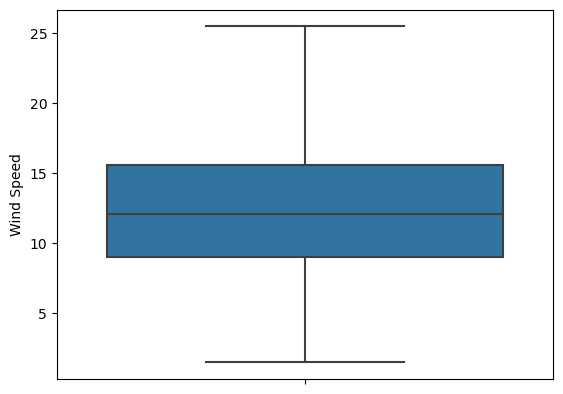

In [31]:
sns.boxplot(data=bike, y='windspeed')
plt.ylabel('Wind Speed')
plt.show()

## Feature Engineering - One Hot Encoding

In [33]:
bike=pd.get_dummies(data=bike,columns=categorical_features,drop_first=True)

In [34]:
pd.options.display.max_columns=None

In [35]:
bike.head()

,temp,hum,windspeed,cnt,season_2,season_3,season_4,yr_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
0,14.110847,80.5833,10.749882,985,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,14.902598,69.6087,16.652113,801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,8.050924,43.7273,16.636703,1349,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,8.200000,59.0435,10.739832,1562,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,9.305237,43.6957,12.522300,1600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [36]:
bike.shape

(730, 29)

In [37]:
#creating a copy for a backup
bikebkp = bike.copy()

## Data preparation

In [38]:
y = bike.pop('cnt')
X = bike

In [39]:
# splitting the dataframe into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=9)

In [85]:
scaling_features = ['temp','hum','windspeed']

In [41]:
# Using StandardScalar for rescaling the features
scalar_feat = StandardScaler()

In [40]:
# Using StandardScalar for rescaling the target as our target is also continuous
scalar_target = StandardScaler()

In [42]:
# Fit the scalar and transform all the numerical columns from train dataset 
X_train[numerical_features]=scalar_feat.fit_transform(X_train[scaling_features])

In [43]:
# Fit the scalar and transform target 
y_train=scalar_target.fit_transform(y_train.to_numpy().reshape(-1,1))

In [44]:
# Transform all the numerical columns from test dataset using scalar fitted on train dataset above
X_test[numerical_features]=scalar_feat.transform(X_test[scaling_features])

In [45]:
# Transform test target using scalar fitted on train dataset above
y_test=scalar_target.transform(y_test.to_numpy().reshape(-1,1))

## Base model using OLS
- Without doing any feature reduction

In [46]:
# Adding a constant for the model to consider the intercept
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

In [47]:
# Define the OLS model from Statsmodel
lr = sm.OLS(y_train,X_train_sm)

In [48]:
# Fit the OLS model on the train dataset
lrm = lr.fit()

In [49]:
# Summary
lrm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     110.0
Date:                Wed, 12 Apr 2023   Prob (F-statistic):          2.97e-203
Time:                        22:38:08   Log-Likelihood:                -289.21
No. Observations:                 584   AIC:                             634.4
Df Residuals:                     556   BIC:                             756.8
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.2439      0.099    -12.568      0.000      -1.438      -1.049
temp             0.4239      0.045      9.416      0.000       0.335       0.512
hum             -0.1142      0.025     -4.484      0.000      -0.164      -0.064
windspeed       -0.1165      0.019     -6.283      0.000      -0.153      -0.080
season_2         0.3514      0.109      3.211      0.001       0.136       0.566
season_3         0.3052      0.127      2.410      0.016       0.056       0.554
season_4         0.7301      0.105      6.928      0.000       0.523       0.937
yr_1             1.0414      0.035     30.129      0.000       0.973       1.109
mnth_2           0.0780      0.089      0.878      0.380      -0.097       0.253
mnth_3           0.3200      0.099      3.220      0.001       0.125       0.515
mnth_4           0.3861      0.150      2.569      0.010       0.091       0.681
mnth_5           0.5439      0.162      3.354      0.001       0.225       0.863
mnth_6           0.4038      0.170      2.381      0.018       0.071       0.737
mnth_7           0.1641      0.187      0.877      0.381      -0.203       0.531
mnth_8           0.3676      0.178      2.061      0.040       0.017       0.718
mnth_9           0.6597      0.157      4.213      0.000       0.352       0.967
mnth_10          0.3761      0.142      2.649      0.008       0.097       0.655
mnth_11          0.0685      0.135      0.509      0.611      -0.196       0.333
mnth_12          0.0726      0.108      0.675      0.500      -0.139       0.284
holiday_1       -0.1085      0.097     -1.115      0.266      -0.300       0.083
weekday_1       -0.0167      0.043     -0.391      0.696      -0.101       0.067
weekday_2        0.0131      0.046      0.281      0.779      -0.078       0.104
weekday_3        0.0633      0.045      1.392      0.164      -0.026       0.153
weekday_4        0.0417      0.046      0.912      0.362      -0.048       0.131
weekday_5       -0.0023      0.046     -0.049      0.961      -0.093       0.089
weekday_6        0.2223      0.063      3.507      0.000       0.098       0.347
workingday_1     0.2075      0.040      5.184      0.000       0.129       0.286
weathersit_2    -0.2408      0.046     -5.248      0.000      -0.331      -0.151
weathersit_3    -1.0570      0.122     -8.693      0.000      -1.296      -0.818
==============================================================================
Omnibus:                      105.033   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              305.113
Skew:                          -0.869   Prob(JB):                     5.57e-67
Kurtosis:                       6.086   Cond. No.                     1.05e+16
==============================================================================

Notes:
[1] Stand

**Observations**
We have gotten a good R2 score for the model. However the number of features are too many.
These many features will not help business to make proper decisions on the factors affecting the bike demand.
Hence taking this as a base model, we will perform the feature reduction techniques.

## Feature Reduction

For reducing the number of features, lets perform hybrid approach i.e. Automated + Manual
1. Automated - Recursive Feature Elimination (RFE)
2. Manual - Using VIF and P-value

In [50]:
X_train.shape

(584, 28)

There are 28 features in total, it makes sense to bring the count down to 10 to 15 for a better business output.
We will take the approach to reduce the features to 15 using automated approach and then firther reduce using manual approach.

#### Recursive Feature Elimination

In [51]:
# Build a liner regression model using Sklearn framework
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [52]:
#RFE
rfe = RFE(lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [53]:
#Features with RFE support and rank
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('temp', True, 1),
 ('hum', False, 5),
 ('windspeed', False, 4),
 ('season_2', True, 1),
 ('season_3', True, 1),
 ('season_4', True, 1),
 ('yr_1', True, 1),
 ('mnth_2', False, 7),
 ('mnth_3', True, 1),
 ('mnth_4', True, 1),
 ('mnth_5', True, 1),
 ('mnth_6', True, 1),
 ('mnth_7', False, 6),
 ('mnth_8', False, 2),
 ('mnth_9', True, 1),
 ('mnth_10', True, 1),
 ('mnth_11', False, 9),
 ('mnth_12', False, 8),
 ('holiday_1', False, 3),
 ('weekday_1', False, 13),
 ('weekday_2', False, 12),
 ('weekday_3', False, 10),
 ('weekday_4', False, 11),
 ('weekday_5', False, 14),
 ('weekday_6', True, 1),
 ('workingday_1', True, 1),
 ('weathersit_2', True, 1),
 ('weathersit_3', True, 1)]

In [54]:
# Selecting columns for which the RFE has given "True" as support
rfe_cols = X_train.columns[rfe.support_]
print(rfe_cols)

Index(['temp', 'season_2', 'season_3', 'season_4', 'yr_1', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_9', 'mnth_10', 'weekday_6', 'workingday_1',
       'weathersit_2', 'weathersit_3'],
      dtype='object')


In [55]:
# Rejected columns
X_train.columns[~rfe.support_]

Index(['hum', 'windspeed', 'mnth_2', 'mnth_7', 'mnth_8', 'mnth_11', 'mnth_12',
       'holiday_1', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5'],
      dtype='object')

As per RFE algorithm,
1. Months Feb to July, Nov and Dec months are NOT good predictors for bike demand
2. Days Monday to Friday are NOT good predictors for bike demand

#### Variance Inflation Factor

In [56]:
# defining a function to calculate and print VIF
def calculate_VIF(df,cols):
    vif = pd.DataFrame()
    vif["feature"] = cols
  
    # calculating VIF for each feature
    vif["VIF"] = [variance_inflation_factor(df[cols].values, i)
                          for i in range(len(cols))]
  
    print(vif)
    return

In [57]:
# Checking VIF for the feature selected by RFE
calculate_VIF(X_train,rfe_cols)

         feature       VIF
0           temp  2.739272
1       season_2  7.547635
2       season_3  3.970949
3       season_4  2.335782
4           yr_1  1.853429
5         mnth_3  1.477469
6         mnth_4  3.417400
7         mnth_5  3.647964
8         mnth_6  2.337517
9         mnth_9  1.263258
10       mnth_10  1.621774
11     weekday_6  1.588179
12  workingday_1  3.780350
13  weathersit_2  1.519257
14  weathersit_3  1.088441


There seems to be no multi-colinearity within the features from the VIF values.

## Building Linear Regression Model

In [58]:
#Defining function to train the model
def train_model(train_df,cols):
    #Adding constant as required by statsmodel
    X_train_sm = sm.add_constant(train_df[cols])
    
    #Training the OLS model
    lr = sm.OLS(y_train,X_train_sm).fit()
    
    #Returning the trained model
    return lr

##### 1. Traning model with RFE selected fearures

In [59]:
lr_1 = train_model(X_train,rfe_cols)
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     178.0
Date:                Wed, 12 Apr 2023   Prob (F-statistic):          3.11e-203
Time:                        22:38:41   Log-Likelihood:                -320.42
No. Observations:                 584   AIC:                             672.8
Df Residuals:                     568   BIC:                             742.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.1702      0.073    -16.026   

--
1. Above summary shows that `mnth_4` feature is having high p-value (0.071) which is > 0.05
2. Removing `mnth_4` feature

In [60]:
# Removing mnth_4 fearture from columns list
cols_2=rfe_cols.drop('mnth_4')

In [61]:
# Checking VIF after removing mnth_4
calculate_VIF(X_train,cols_2)

         feature       VIF
0           temp  2.737748
1       season_2  2.833351
2       season_3  3.961193
3       season_4  2.322504
4           yr_1  1.846727
5         mnth_3  1.225117
6         mnth_5  1.858450
7         mnth_6  1.510417
8         mnth_9  1.256504
9        mnth_10  1.621643
10     weekday_6  1.582093
11  workingday_1  3.747031
12  weathersit_2  1.519253
13  weathersit_3  1.087801


##### 2. Training model after removing `mnth_4` feature

In [62]:
lr_2 = train_model(X_train,cols_2)
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     189.7
Date:                Wed, 12 Apr 2023   Prob (F-statistic):          1.12e-203
Time:                        22:39:27   Log-Likelihood:                -322.10
No. Observations:                 584   AIC:                             674.2
Df Residuals:                     569   BIC:                             739.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.1561      0.073    -15.892   

--
1. Above summary shows that `mnth_6` feature is having high p-value (0.09) which is > 0.05
2. Removing `mnth_6` feature

In [63]:
# Removing mnth_6 fearture from columns list
cols_3=cols_2.drop('mnth_6')

# Checking VIF after removing mnth_6
calculate_VIF(X_train,cols_3)

         feature       VIF
0           temp  2.536958
1       season_2  2.516218
2       season_3  3.932390
3       season_4  2.322503
4           yr_1  1.844551
5         mnth_3  1.206205
6         mnth_5  1.605875
7         mnth_9  1.243182
8        mnth_10  1.614292
9      weekday_6  1.557091
10  workingday_1  3.654394
11  weathersit_2  1.519227
12  weathersit_3  1.086874


##### 3. Training model after removing `mnth_6` feature

In [64]:
lr_3 = train_model(X_train,cols_3)
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     203.4
Date:                Wed, 12 Apr 2023   Prob (F-statistic):          3.23e-204
Time:                        22:39:53   Log-Likelihood:                -323.58
No. Observations:                 584   AIC:                             675.2
Df Residuals:                     570   BIC:                             736.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.1269      0.071    -15.914   

--
1. Above summary shows that `mnth_5` feature is having high p-value (0.088) which is > 0.05
2. Removing `mnth_5` feature

In [65]:
# Removing mnth_5 fearture from columns list
cols_4=cols_3.drop('mnth_5')

# Checking VIF after removing mnth_5
calculate_VIF(X_train,cols_4)

         feature       VIF
0           temp  2.481537
1       season_2  2.124447
2       season_3  3.870619
3       season_4  2.320853
4           yr_1  1.843461
5         mnth_3  1.182019
6         mnth_9  1.243101
7        mnth_10  1.612700
8      weekday_6  1.553409
9   workingday_1  3.632216
10  weathersit_2  1.506903
11  weathersit_3  1.086687


##### 4. Training model after removing `mnth_5` feature

In [66]:
lr_4 = train_model(X_train,cols_4)
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     219.4
Date:                Wed, 12 Apr 2023   Prob (F-statistic):          9.12e-205
Time:                        22:40:20   Log-Likelihood:                -325.07
No. Observations:                 584   AIC:                             676.1
Df Residuals:                     571   BIC:                             733.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.1110      0.070    -15.800   

--
1. Above summary shows that `mnth_3` feature is having high p-value (0.131) which is > 0.05
2. Removing `mnth_3` feature

In [67]:
# Removing mnth_3 fearture from columns list
cols_5=cols_4.drop('mnth_3')

# Checking VIF after removing mnth_3
calculate_VIF(X_train,cols_5)

         feature       VIF
0           temp  2.449661
1       season_2  2.124269
2       season_3  3.855635
3       season_4  2.244056
4           yr_1  1.833977
5         mnth_9  1.243095
6        mnth_10  1.612235
7      weekday_6  1.533629
8   workingday_1  3.514960
9   weathersit_2  1.500830
10  weathersit_3  1.086146


##### 5. Training model after removing `mnth_3` feature

In [68]:
lr_5 = train_model(X_train,cols_5)
print(lr_5.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     238.6
Date:                Wed, 12 Apr 2023   Prob (F-statistic):          1.79e-205
Time:                        22:41:48   Log-Likelihood:                -326.24
No. Observations:                 584   AIC:                             676.5
Df Residuals:                     572   BIC:                             728.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.0905      0.069    -15.788   

--
1. Above summary shows that all the features are having very low p-values
2. All the fetures are statistically significant for the model

##### Final set of feature and model

In [69]:
#Final set of features are present in cols_5 list
cols_final = cols_5

#Final model is lr_5
lr_final = lr_5

## Residual Analysis

For residual analysis, we will perform below steps
1. Predict 'y' using the trained model on training dataset
2. Calculate error or residual as difference between actual 'y' and predicted 'y'
3. Plot the distribution of residuals - it should be normally distributed with mean=0
4. Check for Homoscedasticity i.e. constant variance in residuals 

In [70]:
# Since col_5 has the final set of features, creating a final dataset with these feautes for further analysis
X_train_sm_final = sm.add_constant(X_train[cols_final])

In [71]:
# predict y using the final trained model
y_train_pred = lr_final.predict(X_train_sm_final)

In [72]:
# Reshape y_train (as it was reshaped for fitting the scalar)
y_train = y_train.reshape(-1,)

In [73]:
# calculate residual as difference between actual 'y' and predicted 'y'
res = y_train - y_train_pred

## Assumptions of Linear Regression

### 1. Residuals are normally distributed with mean 0

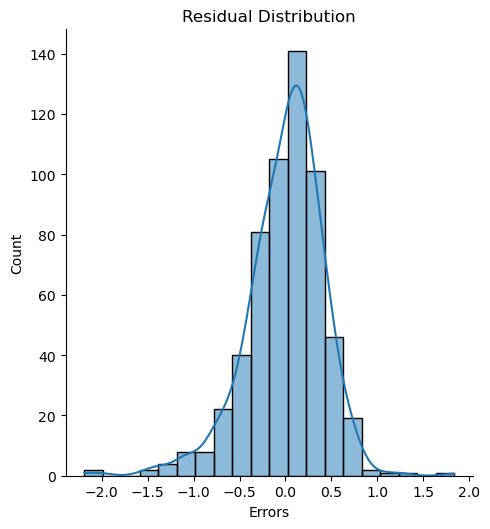

In [74]:
# Plot the histogram of the residuals
sns.displot(res, bins = 20, kde=True)
plt.title('Residual Distribution') 
plt.xlabel('Errors')
plt.show()

Above plot shows that the residuals are normally distributed (bell curve) and has mean equal to 0.

#### 2. Homoscedasticity

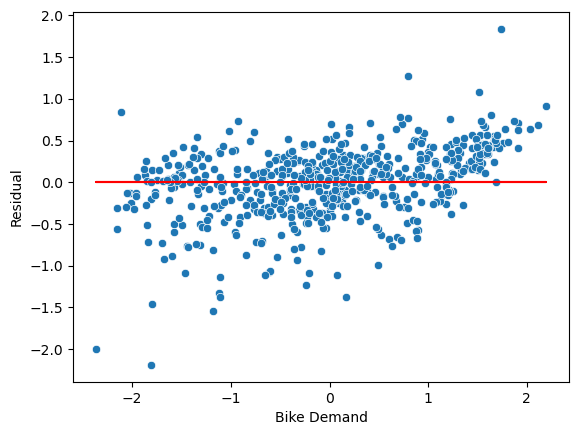

In [75]:
# plot scatter plot for residuals
sns.scatterplot(x=y_train,y=res)
plt.plot(y_train, [0]*len(y_train), color='Red')
plt.xlabel('Bike Demand')
plt.ylabel('Residual')
plt.show()

Above scatter plot doesnt show any pattern and there are almost equal number of points above and below the Zero line.
Hence we can conclude that the resudals are having constant variance.

#### 3. Linear relation between independent features and target

In [93]:
numerical_features.remove('atemp')

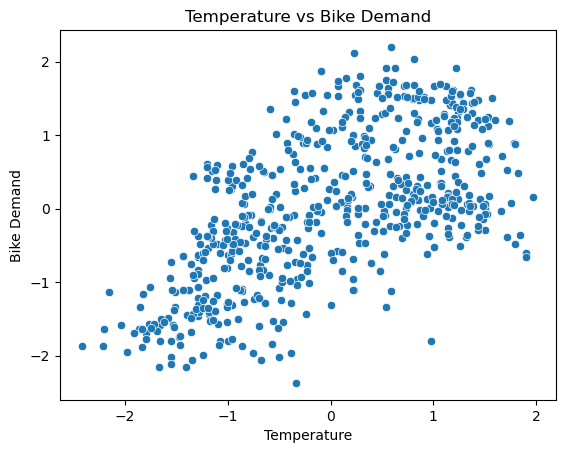

In [103]:
sns.scatterplot(x=X_train['temp'], y=y_train)
plt.title("Temperature vs Bike Demand")
plt.xlabel('Temperature')
plt.ylabel('Bike Demand')
plt.show()

<AxesSubplot:>

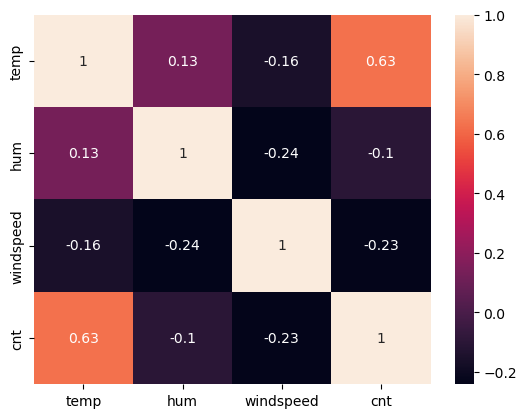

In [97]:
sns.heatmap(bikebkp[numerical_features].corr(), annot=True)

Above pair plot and correlation plot shows that there is some linear relation between target `cnt` and the predictor variables.

#### 4. No Multicolinearity

In [98]:
#Calcualte VIF for all independent features to check for multicolinearity
calculate_VIF(X_train,cols_final)

         feature       VIF
0           temp  2.449661
1       season_2  2.124269
2       season_3  3.855635
3       season_4  2.244056
4           yr_1  1.833977
5         mnth_9  1.243095
6        mnth_10  1.612235
7      weekday_6  1.533629
8   workingday_1  3.514960
9   weathersit_2  1.500830
10  weathersit_3  1.086146


Above VIF values are all less than 5. This means that there is no multi-colinearity in within the dataset.

## Predictions - Test Dataset

We need to perform all the steps performed on training dataset on the test data as well.
- Test dataset is already scaled.
- Remove features as per the RFE, VIF and P-value analysis done on training dataset
- Add constant


In [106]:
## Selecting only final set of features present in cols_final for the test dataset
## Adding constant for statsmodel API
X_test_sm = sm.add_constant(X_test[cols_final])

# Predicting 'y' for 'X_test_sm' using the final trained model
y_test_pred = lr_final.predict(X_test_sm)

In [107]:
# Checking for R2 score on test data
r2 = r2_score(y_test, y_test_pred)
round(r2,4)

0.8377

**83.7% R2 on test data with 82.1% R2 on train data is a good.**

Calculating Adjusted R2 on the test predictions

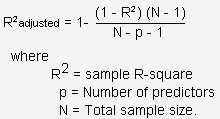

In [108]:
#Calculating adjusted R2
adjusted_r2 = round(1-(1-r2)*(X_test[cols_final].shape[0]-1)/(X_test[cols_final].shape[0]-X_test[cols_final].shape[1]-1),4)
print(adjusted_r2)

0.8244


**82.4% Adjusted R2 on test data with 81.8% Adjusted R2 on train data is a good.
We will further evaluate the model using viualizations.**

##### Plotting actual vs predicted values for bike demand on test data

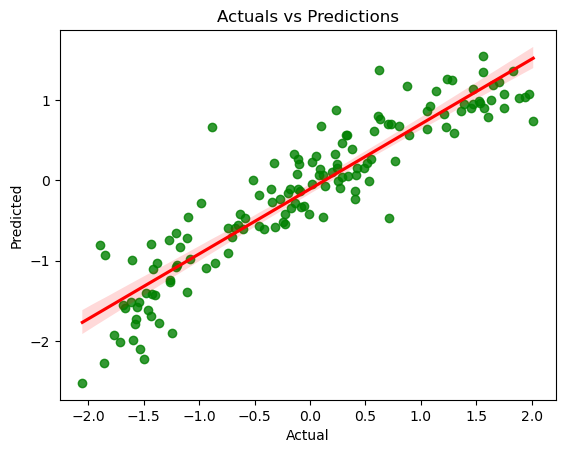

In [109]:
sns.regplot(x=y_test, y=y_test_pred, fit_reg=True,scatter_kws={"color": "green"}, line_kws={"color": "red"})
plt.title('Actuals vs Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

**As seen from above plot, the actual values of 'y' and predicted values of 'y' are following a linear relationship. 
This means that the model is predicting bike demand very well and very close to the actual demands.**

# Conclusion

For categorical fields like `season` , `month` , `weekday` and `weathersit` have data in the form of numbers.
These can be converted into proper names for interpreting them easily.
For example, `season_spring` is more readable/clear to business than `season_1`.

So, using the data dictionary, we will convert these values into a proper readable values.
1. season 
    - 1 = spring
    - 2 = summer
    - 3 = fall
    - 4 = winter
2. Month
    - 1 = Jan
    - 2 = Feb
    - .
    - .
    - 12 = Dec
3. Weekday
    - 0 = Sunday
    - 1 = Monday
    - .
    - 6 = Saturday
4. Weathersit (abbrevating/shortening the big discription from data dictionary)
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy = Clear
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist = Misty
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds = LightRainSnow
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog = HeavyRainSnow

In [111]:
cat_map = {'season_1':'spring', 'season_2':'summer', 'season_3':'fall', 'season_4':'winter',
              'mnth_1': 'Jan', 'mnth_2': 'Feb', 'mnth_3': 'Mar', 'mnth_4': 'Apr', 'mnth_5':'May','mnth_6':'Jun',
             'mnth_7':'Jul','mnth_8':'Aug', 'mnth_9':'Sep','mnth_10':'Oct','mnth_11':'Nov','mnth_12':'Dec',
              'weekday_0':'Sun','weekday_1':'Mon','weekday_2':'Tue','weekday_3':'Wed',
               'weekday_4':'Thu','weekday_5':'Fri','weekday_6':'Sat',
              'weathersit_1': 'Clear','weathersit_2': 'Misty','weathersit_3': 'LightRainSnow','weathersit_4': 'HeavyRainSnow'}

In [133]:
influential_factors= pd.DataFrame(round(lr_final.params,4), columns=['coeff']).reset_index().rename(columns={'index':'feature'})

In [134]:
influential_factors['feature']=influential_factors['feature'].map(lambda x: cat_map[x] if x in cat_map else x)

In [135]:
influential_factors

,feature,coeff
0,const,-1.0905
1,temp,0.4645
2,summer,0.6018
3,fall,0.3996
4,winter,0.7071
5,yr_1,1.0546
6,Sep,0.3933
7,Oct,0.2565
8,Sat,0.2577
9,workingday_1,0.2752


As per above model parameters, the featured affecting bike demand are
1. Temperature
2. Seasons
3. Year
4. Months - September and October
5. Day - Saturday
6. Working day 
7. Weather

_cnt = -1.0905 + 0.4645 * temp + 0.6018 * summer + 0.3996 * fall + 0.7071 * winter + 1.0546 * year + 0.3933 * September + 0.2565 * october + 0.2577 * saturday + 0.2752 * workingday - 0.3554 * misty - 1.4226 * lightsnowrain_

### ##########END##########